# NeuroMet

Instructions:
* this notebook cannot be used for two different analysis at the same time. If you are unsure if someone is using it click on File / Make a copy and work with the copy.
* to run a cell press Umschalt (Shift) + Enter
* to correctly run the workflow _EVERY_ cell has to be ran
* When you run a cell, there is at first an [*] on the left, then a number (maybe an updated number) when the cell ran.
* normally the only thing to adjust in the settings is 1.6 Subject

## 0. External Modules

red warnings are normal in next cell

In [ ]:
import nipype.interfaces.freesurfer
from nipype.interfaces.freesurfer import Info

Info.version()  


In [ ]:
! echo $FREESURFER_HOME

In [ ]:
import importlib
import workflows
importlib.reload(workflows)
from workflows.NeuroMet_dev_fs7 import NeuroMet as NeuroMet

Just some external modules required to run correctly the notebook - nothing to edit - just press **shift + enter**

In [ ]:
import os
import glob
from IPython.display import Image
%matplotlib inline

## 1. Settings

### 1.1 Directories and Folders

In [ ]:
## Paths
raw_data_dir = '/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet'
base_dir = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET'
temp_dir = '/home/WorkFlowTemp/NeuroMet'

#Working directory
w_dir = os.path.join(base_dir, 'Structural_analysis_fs7')

#Excel file with masks
mask_file = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/List_UNI_DEN_Mask.xlsx'

In [ ]:
import pandas as pd
df = pd.read_excel(mask_file, header =None, names=['ids', 'masks', 'notes'])
df = df[df.masks.notnull()]

In [ ]:
subs = [i[-3:] for i in list(df.ids.values)]
subs

### 1.2 Matlab

The path where SPM is and the command to call matlab. *Everything should be fine as is*

In [8]:
spm_path='/opt/spm12'
matlab_command = "matlab -nodesktop -nosplash"

### 1.3 FSL

Set format for FSL output files, i.e. NIFTI_GZ, NIFTI

References: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslEnvironmentVariables

In [9]:
fsl_file_format = 'NIFTI_GZ'

### 1.4 QDec

In [10]:
qdec_subfolder = ''

### 1.5 Others

* **cores** : 6, if you don't have to run/work on something else at the same time
* **overwrite**: If the "_copy from raw data_" step should overwrite the copied files
* **omp_nthreads**: cores/2 is a good choice

In [11]:
cores = 6
overwrite = False
omp_nthreads = 3

### 1.5 Subjects

**subject_list**:
* to analyze all subjects cut&paste below: `subject_list = [ x.split('/')[-1][8:11] for x in os.listdir(w_dir) if x.startswith('NeuroMet')]`
* to analyse only some subjects use the format: `subject_list = ['subject number', 'subject number' ... ]` i.e.: `subject_list = ['001']` or `subject_list = ['001', '003']` 

**qdec_subjects**:
* to analyze all subjects in folder: `qdec_subjects = []`
* to analyze the same subjects as in `subject_list`: `qdec_subjects = subject_list`
* to analyse only some subjects use the format: `qdec_subjects = ['subject number', 'subject number' ... ]` i.e.: `qdec_subjects = ['001']` or `qdec_subjects = ['001', '003']` 

In [12]:
#subject_list = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020' ]
subject_list = subs
qdec_subjects = []

In [13]:
#subject_list

## 2. Create a NeuroMet Object

In [ ]:
neuromet_creator = NeuroMet(subject_list, temp_dir, w_dir, omp_nthreads, raw_data_dir, overwrite, spm_path, matlab_command, fsl_file_format, qdec_subjects, qdec_subfolder)

# Workflow - 1st part - SPM Segment and Mask generation

## 3. Copy from raw data

In [ ]:
neuromet_creator.copy_from_raw_data()

In [ ]:
neuromet = neuromet_creator.make_neuromet1_workflow()

In [ ]:
neuromet.write_graph(graph2use = 'colored', dotfilename = './neuromet_1st_part')
Image(filename='neuromet_1st_part.png')

## 4. Run Pipeline

In [ ]:
%%time
neuromet.run('MultiProc', plugin_args={'n_procs': cores})

# Workflow 2. Part - Create combined image and Freesurfer

## 05. Print current Subjects 

In [ ]:
print(subject_list)

## 06.Edit Subjects list 

**Subject List**:
* to analyze all subjects cut&paste below: `subject_list = [ x.split('/')[-1][8:11] for x in uni ]` already existing analyses will _NOT_ be run again neither overwritten
* to analyse only some subjects cut&paste below something with the format: `subject_list = ['subject number', 'subject number' ... ]` i.e.: `subject_list = ['001']` or `subject_list = ['001', '003']
* leave the next cell commented to mantain the actual list

In [16]:
# Uncomment here for all subjects:
#subject_list = [ x.split('/')[-1][8:11] for x in uni ]

# only some subjects? Then edit here:  
#subject_list = ['001', '002'] # format: ['subid1', 'subid2', ....]

subject_list = ['001']

## Check if all the brain masks are present and gzipped

In [17]:
#neuromet_creator.check_gz_masks(subject_list)


## SetUp Workflow
Just run this cell to setup the Workflow - nothing to edit

In [18]:
neuromet_creator = NeuroMet(subject_list, temp_dir, w_dir, omp_nthreads, raw_data_dir, overwrite, spm_path, matlab_command, fsl_file_format, qdec_subjects, qdec_subfolder)
neuromet2 = neuromet_creator.make_neuromet2_workflow()

## Draw Workflow's Graph
Run this cell to draw the workflow's graph

200616-13:51:09,820 nipype.workflow INFO:
	 Generated workflow graph: ./neuromet_2.png (graph2use=colored, simple_form=True).


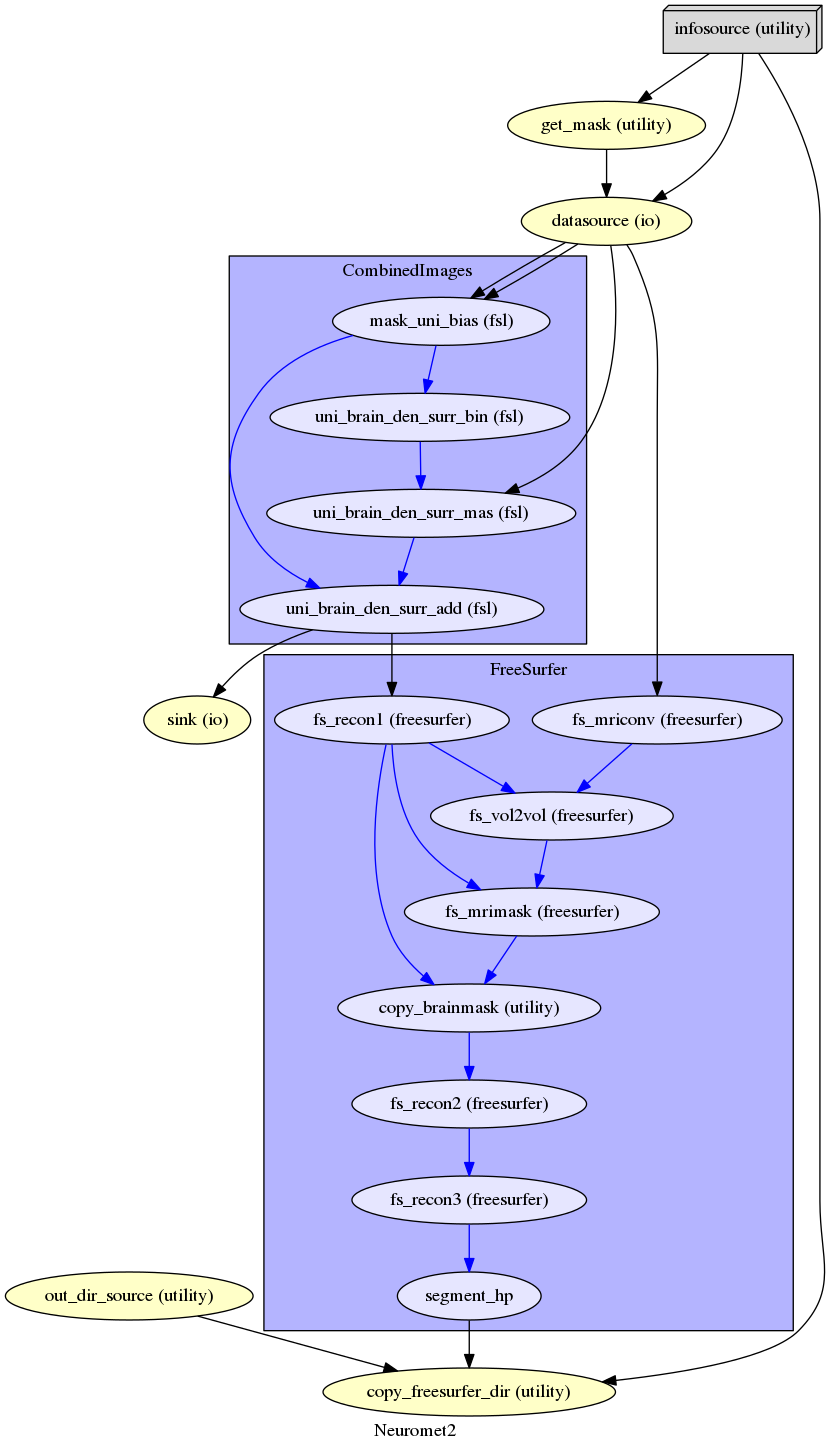

In [19]:
neuromet2.write_graph(graph2use = 'colored', dotfilename = './neuromet_2')
Image(filename='neuromet_2.png')

## Run Freesurfer Analysis
run the cell below to run the analysis

In [ ]:
%%time
neuromet2.run('MultiProc', plugin_args={'n_procs': cores})

200616-13:51:13,34 nipype.workflow INFO:
	 Workflow Neuromet2 settings: ['check', 'execution', 'logging', 'monitoring']
200616-13:51:13,254 nipype.workflow INFO:
	 Running in parallel.
200616-13:51:13,369 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 6/6.
200616-13:51:13,440 nipype.workflow INFO:
	 [Node] Setting-up "Neuromet2.get_mask" in "/home/WorkFlowTemp/NeuroMet/Neuromet2/_subject_id_001/get_mask".
200616-13:51:13,473 nipype.workflow INFO:
	 [Node] Running "get_mask" ("nipype.interfaces.utility.wrappers.Function")
200616-13:51:13,547 nipype.workflow INFO:
	 [Node] Finished "Neuromet2.get_mask".
200616-13:51:15,330 nipype.workflow INFO:
	 [Job 0] Completed (Neuromet2.get_mask).
200616-13:51:15,338 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 6/6.
200616-13:51:15,392 nipype.workflow INFO:
	 [Node] Setting-up "Neuromet2.datasource" in "/h

recon-all -autorecon1 -i /home/WorkFlowTemp/NeuroMet/Neuromet2/CombinedImages/_subject_id_001/uni_brain_den_surr_add/NeuroMet001.DEN_mp2rage_orig_reoriented_masked_maths.nii.gz -hires -mprage -openmp 3 -subjid recon_all -sd /home/WorkFlowTemp/NeuroMet/Neuromet2/FreeSurfer/_subject_id_001/fs_recon1 -expert /home/WorkFlowTemp/NeuroMet/Neuromet2/FreeSurfer/_subject_id_001/fs_recon1/expert.opts
200616-13:51:43,436 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200616-13:51:43,438 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_001/NeuroMet001.DEN_mp2rage_orig_reoriented_masked_maths.nii.gz -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet001/NeuroMet001.mUNIbrain_DENskull_SPMmasked.nii.gz
200616-13:51:45,357 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 27.75/28.15, Free processors: 2/6.
                   

## 07. Qdec

In [ ]:
s = neuromet_creator.show_qdec_stuff()
print(s)

In [ ]:
%%bash -s "$w_dir"
SUBJECTS_DIR=$1
cd $SUBJECTS_DIR
qdec&

## 08. Extract Hippocampal volumes

In [ ]:
%%bash -s "$w_dir" "$subject_list"
SUBJECTS_DIR=$1
echo $FREESURFER_HOME
echo $SUBJECTS_DIR
subject_list=$2
cmd="/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/bash-scripts/HippocampalVolumeExtraction"
cd $SUBJECTS_DIR
$cmd ${subject_list//[\',\[\]]}

In [ ]:
import pandas as pd
out_file = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis'
df = pd.read_csv(out_file, sep = ' ')
writer = pd.ExcelWriter('HippocampusSubfieldVolume.xlsx')
df.to_excel(writer,'HippocampusSubfieldVolume')
writer.save()

In [ ]:
## Vergleich 2 Freesurfer Ordner

In [ ]:
b = [ i.split('/')[-1] for i in glob.glob('/media/drive_s/AG/AG-Floeel-Imaging/02-User/TheresaKoebe/NeuroMet_Project/Structural_analysis/NeuroMet027/NeuroMet027.freesurfer/*/*')] 

In [ ]:
a = [ i.split('/')[-1] for i in glob.glob('/media/drive_s/AG/AG-Floeel-Imaging/02-User/TheresaKoebe/NeuroMet_Project/Structural_analysis/NeuroMet026/NeuroMet026.freesurfer/*/*')] 

In [ ]:
a

In [ ]:
set(a) - set(b)

In [ ]:
c = [ i.split('/')[-1] for i in glob.glob('/media/drive_s/AG/AG-Floeel-Imaging/02-User/TheresaKoebe/NeuroMet_Project/Structural_analysis/NeuroMet028/NeuroMet028.freesurfer/*/*')] 

In [ ]:
set(a) - set(c)